<a href="https://colab.research.google.com/github/Atharva-Gaykar/Deep_Learning/blob/main/notebooks/text_data/Fine_shiv_bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:


import pandas as pd

work_dt= pd.read_csv('/content/drive/MyDrive/shiv_data.csv')

In [ ]:
work_dt.head(3)

,input,context,target
0,When and where was Chhatrapati Shivaji Maharaj...,"Chhatrapati Shivaji Maharaj, born on February ...","Shivaji Maharaj was born on February 19, 1630,..."
1,Who were Shivaji Maharaj's parents?,"Chhatrapati Shivaji Maharaj, born on February ...",Shivaji Maharaj's parents were Shahaji Bhosale...
2,What was Shivaji Maharaj's first fort capture?,"At the age of 16, he captured his first fort, ...",Shivaji Maharaj captured Torna fort as his fir...


In [ ]:
work_dt.shape[0]

1500

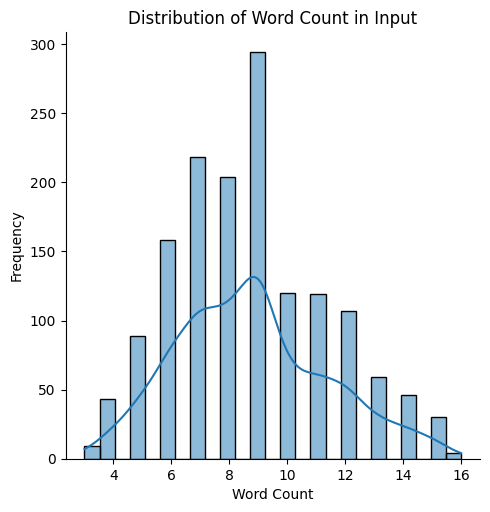

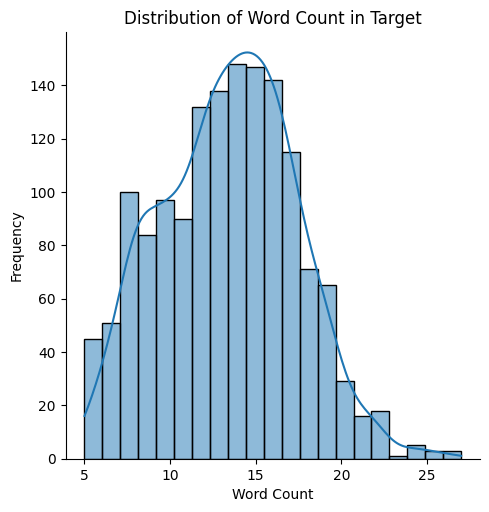

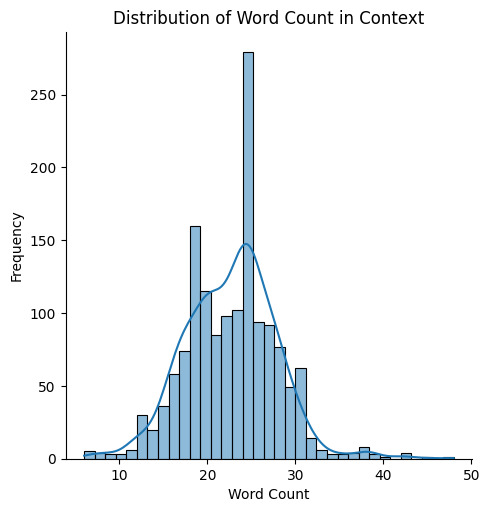

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

work_dt['input_word_count'] = work_dt['input'].apply(lambda x: len(str(x).split()))
work_dt['target_word_count'] = work_dt['target'].apply(lambda x: len(str(x).split()))
work_dt['context_word_count'] = work_dt['context'].apply(lambda x: len(str(x).split()))


sns.displot(work_dt['input_word_count'], kde=True)
plt.title('Distribution of Word Count in Input')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()
print('\n')

sns.displot(work_dt['target_word_count'], kde=True)
plt.title('Distribution of Word Count in Target')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()


sns.displot(work_dt['context_word_count'], kde=True)
plt.title('Distribution of Word Count in Context')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

In [ ]:
list_dr=['input_word_count','target_word_count','context_word_count']
work_dt=work_dt.drop(list_dr,axis=1)

In [ ]:

from datasets import Dataset


In [ ]:
def format_data(row):
    return {
        "input": f"question: {row['input']} context: {row['context']}",
        "output": row["target"]
    }

dataset = Dataset.from_pandas(work_dt).map(format_data, remove_columns=work_dt.columns.tolist())


Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [ ]:
dataset[0]

{'input': 'question: When and where was Chhatrapati Shivaji Maharaj born? context: Chhatrapati Shivaji Maharaj, born on February 19, 1630, in Shivneri Fort, Maharashtra, was the son of Shahaji Bhosale and Jijabai.',
 'output': 'Shivaji Maharaj was born on February 19, 1630, at Shivneri Fort in Maharashtra.'}

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from peft import LoraConfig, get_peft_model, TaskType

model_name = "google/flan-t5-base"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# LoRA configuration
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q", "v"] , # key LoRA targets for T5 attention
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM
)

model = get_peft_model(model, lora_config)


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
import nltk
from datasets import load_dataset

import numpy as np
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, TrainingArguments, Trainer, DataCollatorForSeq2Seq
from datasets import load_dataset
from peft import get_peft_model, LoraConfig, TaskType
import torch

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")

In [ ]:


data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

In [ ]:
prefix = "Answer based on the following context: "

def preprocess_function(examples):
    inputs = [prefix + text for text in examples["input"]]

    model_inputs = tokenizer(
        inputs,
        max_length=70,
        truncation=True,
        padding="max_length"
    )

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples["output"],
            max_length=70,
            truncation=True,
            padding="max_length"
        )

    labels["input_ids"] = [
        [token if token != tokenizer.pad_token_id else -100 for token in label]
        for label in labels["input_ids"]
    ]

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


In [ ]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3950: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [ ]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    learning_rate=3e-4,
    per_device_train_batch_size=4,
    weight_decay=0.02,
    num_train_epochs=3,
    predict_with_generate=True,
    logging_strategy="steps",
    logging_steps=5,
    logging_first_step=True,
    disable_tqdm=False,
    save_strategy="epoch",
    save_total_limit=3,

    # Since you are using all data for training only
         # ✅ no validation
    load_best_model_at_end=False,  # ✅ no best model if no eval

    report_to="none",
    push_to_hub=False
)





In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,  # ✅ Only train_dataset
    tokenizer=tokenizer,
    data_collator=data_collator,
)


/tmp/ipython-input-75663927.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
No label_names provided for model class `PeftModelForSeq2SeqLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
trainer.train()

Step,Training Loss
1,1.192400
5,1.655100
10,1.659800
15,1.256600
20,1.137900
25,0.938200
30,1.112800
35,0.853100
40,0.948000
45,0.725200


TrainOutput(global_step=1125, training_loss=0.6417511310577393, metrics={'train_runtime': 187.0792, 'train_samples_per_second': 24.054, 'train_steps_per_second': 6.013, 'total_flos': 422958412800000.0, 'train_loss': 0.6417511310577393, 'epoch': 3.0})

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch


# Ensure device compatibility
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Inference function
def generate_answer(question, context):
    input_text = f"question: {question} context: {context}"
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True)

    # Move inputs to same device as model
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Generate output
    outputs = model.generate(**inputs, max_new_tokens=100)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Test examples
examples = [
    {
        "question": "When was Chhatrapati Shivaji Maharaj born?",
        "context": "Chhatrapati Shivaji Maharaj was born on February 19, 1630, at Shivneri Fort near Junnar, which is now in Pune district. He was renowned for his courage, leadership, and strategic military prowess. He is remembered as a great warrior and the founder of the Maratha Empire in India."
    },
    {
        "question": "which fort did shivaji capture at the age of 16?",
        "context": "In 1646, at the age of 16, Shivaji captured the Torna Fort. He took advantage of the prevailing confusion in the Bijapur court due to the illness of Sultan Mohammed Adil Shah and seized a large treasure he found there."
    },
    {
        "question": "What happened during Shivaji's night attack on Shaista Khan?",
        "context": "On the night of April 5, 1663, Shivaji led a daring night attack on Shaista Khan's camp. Along with 400 men, he broke into the Lal Mahal, wounded Khan (who lost three fingers), and killed his son and several others in the ensuing scuffle. Humiliated, Shaista Khan took refuge outside Pune and was punished by Aurangzeb with a transfer to Bengal."
    },
    {
        "question": "Why did Shivaji sack Surat and what did he gain?",
        "context": "In retaliation for Shaista Khan's attacks and to replenish his depleted treasury, Shivaji sacked the wealthy Mughal port city of Surat in 1664, plundering over Rs 10 million. In 1665, he also conducted a naval raid on Portuguese-held Basrur in present-day Karnataka, gaining a large plunder."
    }
]

# Run inference
for ex in examples:
    print(f"Q: {ex['question']}")
    print(f"A: {generate_answer(ex['question'], ex['context'])}")
    print("-" * 80)


Q: When was Chhatrapati Shivaji Maharaj born?
A: Shivaji Maharaj was born on February 19, 1630.
--------------------------------------------------------------------------------
Q: which fort did shivaji capture at the age of 16?
A: Torna Fort.
--------------------------------------------------------------------------------
Q: What happened during Shivaji's night attack on Shaista Khan?
A: Shivaji led a night attack on Shaista Khan's camp, killing his son and others.
--------------------------------------------------------------------------------
Q: Why did Shivaji sack Surat and what did he gain?
A: Shivaji sacked Surat in 1664, plundering Rs. 10 million.
--------------------------------------------------------------------------------


In [ ]:
from peft import PeftModel
# Suppose you used Hugging Face Trainer + PEFT
from transformers import T5Tokenizer
from peft import PeftModel

model_path = "/content/drive/MyDrive/shiv_lora"
model.save_pretrained(model_path)         # <-- CRUCIAL for LoRA
tokenizer.save_pretrained(model_path)